# Lambert W x Gamma Regression (California Housing Data)

This is in comparison to the Gamma Regression notebook for the same dataset.  The Lambert W x Gamma distribution adds an additional tail parameter for adding heavier weight to larger values in the target variable (compared to what a Gamma distribution could afford).

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/Gamma_Regression_CaliforniaHousing.ipynb)

# Imports

In [3]:
import xgboostlss
from xgboostlss.model import *
from xgboostlss.distributions.Weibull import *
from xgboostlss.distributions.LambertWGamma import *
from xgboostlss.distributions.LambertWWeibull import *


from sklearn import datasets
from sklearn.model_selection import train_test_split
import multiprocessing
import seaborn as sns

# Data

In [64]:
n_cpu = multiprocessing.cpu_count()
print(n_cpu)
housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

8


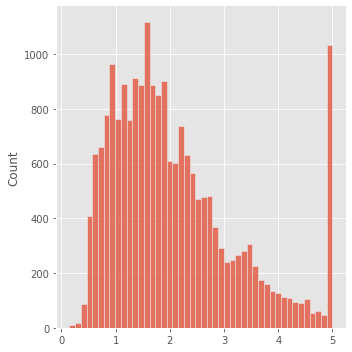

In [65]:
sns.displot(y)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu - 1)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [68]:
# Specifies Gamma distribution with exp response function and option to stabilize Gradient/Hessian. Type ?Gamma for an overview.
xgblss = XGBoostLSS(
     SkewLambertWGamma(stabilization="L2",     # Options are "None", "MAD", "L2".
          response_fn="exp",      # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
          loss_fn="nll"           # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
         )
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [92]:
param_dict = {
    "learning_rate":              ["float", {"low": 0.001,   "high": 0.1,     "log": False}],
    "eta":              ["float", {"low": 0.001,   "high": 1.,     "log": True}],
    "max_depth":        ["int",   {"low": 3,      "high": 9,    "log": False}],
    "gamma":            ["float", {"low": 0.00001,   "high": 1.,    "log": True}],
    "subsample":        ["float", {"low": 0.25,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.25,    "high": 1.,   "log": False}],
    "min_child_weight": ["float", {"low": 0.0001,   "high": 15.,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=150,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=10,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=20,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=5                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-12-24 18:25:32,328] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


Using 5 out of 20 trials for (random) startup


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-12-24 18:26:21,264] Trial 0 finished with value: 2489.1016602 and parameters: {'learning_rate': 0.022977323937884212, 'eta': 0.40944626946107576, 'max_depth': 4, 'gamma': 0.3917910760336115, 'subsample': 0.6163083915961218, 'colsample_bytree': 0.7088078971769842, 'min_child_weight': 0.9213167377893986, 'booster': 'gbtree'}. Best is trial 0 with value: 2489.1016602.


invalid value encountered in subtract


[I 2023-12-24 18:28:02,557] Trial 1 finished with value: 67061.328125 and parameters: {'learning_rate': 0.052323380799421386, 'eta': 0.00776965087989536, 'max_depth': 4, 'gamma': 2.533415036203637e-05, 'subsample': 0.8038302221492275, 'colsample_bytree': 0.5809819171719648, 'min_child_weight': 0.000659821286920084, 'booster': 'gbtree'}. Best is trial 0 with value: 2489.1016602.
[I 2023-12-24 18:28:56,674] Trial 2 finished with value: 204305.946875 and parameters: {'learning_rate': 0.08811376608892661, 'eta': 0.006641396148565795, 'max_depth': 5, 'gamma': 0.00030227321391357434, 'subsample': 0.7215909316596125, 'colsample_bytree': 0.6848783576421588, 'min_child_weight': 0.12743486719916242, 'booster': 'gbtree'}. Best is trial 0 with value: 2489.1016602.
[I 2023-12-24 18:29:40,478] Trial 3 finished with value: 2471.3418944 and parameters: {'learning_rate': 0.02731609263601522, 'eta': 0.007145911642048772, 'max_depth': 4, 'gamma': 0.00043432991049139187, 'subsample': 0.35812322549006537, 

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

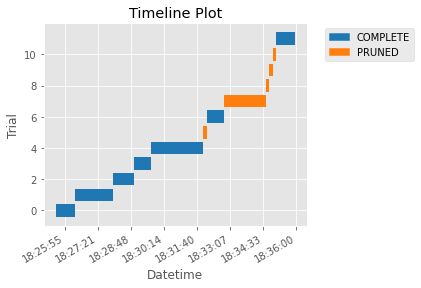

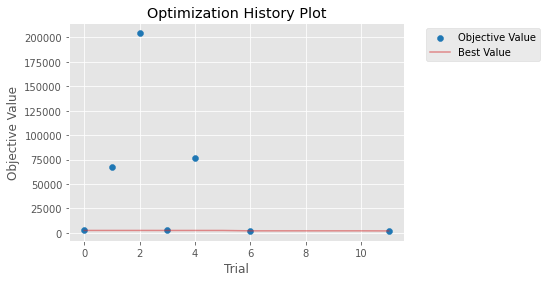

In [93]:
import optuna
optuna.visualization.matplotlib.plot_timeline(xgblss.optuna_study)
optuna.visualization.matplotlib.plot_optimization_history(xgblss.optuna_study)

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.


<Axes: title={'center': 'Parallel Coordinate Plot'}>

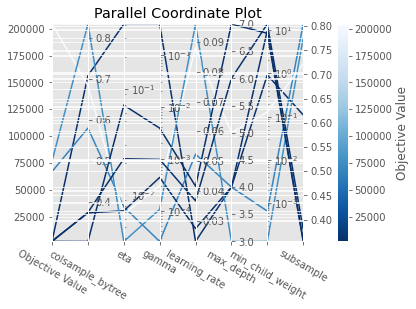

In [94]:
param_plot = [k for k, v in param_dict.items() if len(v[1]) > 1]
optuna.visualization.matplotlib.plot_parallel_coordinate(xgblss.optuna_study, params=param_plot)

# Model Training

In [95]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [96]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.5, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [97]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.727723,3.424630,1.750199,2.107294,1.478147,1.380566,1.838915,1.255403,1.760067,2.018698,...,2.200059,2.142711,1.068612,1.156722,1.982480,1.776622,3.150239,1.631751,1.522489,2.043881
1,0.915441,1.852025,0.768962,1.168025,1.613013,0.765494,0.985550,1.594601,1.364748,0.864596,...,1.096125,1.134333,1.511866,1.047758,1.308226,0.635962,1.046006,0.592114,0.472102,1.243106
2,0.830831,1.099393,2.241527,1.309324,0.213462,1.284272,1.382192,0.977150,0.616058,1.295340,...,1.091497,1.588771,1.243556,1.204707,0.887438,1.248449,1.858092,1.078854,1.785524,0.887801
3,1.689438,1.662107,1.288268,1.254903,1.372429,0.412805,0.890498,2.662781,0.778200,2.123757,...,2.123573,1.847210,1.387066,1.116189,0.846449,1.444437,1.331493,1.438753,1.514878,1.613522
4,4.496538,4.519797,4.178112,5.368898,3.866238,1.763699,3.427269,4.540780,4.679951,3.933164,...,4.047219,4.702398,4.236659,2.978249,3.642388,4.823825,3.068027,6.417112,6.728726,5.043763


In [98]:
pred_quantiles.head()

,quant_0.05,quant_0.5,quant_0.95
0,1.066049,1.804008,2.853781
1,0.463366,0.885684,1.499507
2,0.679451,1.287364,2.140258
3,0.840859,1.537886,2.527992
4,2.594239,4.121616,6.258300


In [99]:
pred_params.head()

,concentration,rate,skewweight
0,10.291183,5.568595,0.000374
1,7.549735,8.245039,0.000157
2,9.009233,6.749825,0.000153
3,9.721216,5.947929,0.000151
4,14.593370,3.460621,0.000671


In [100]:
xgblss.dist.get_params_df_loss(pred_params[["concentration", "rate", "skewweight"]], 
                               pd.Series(y_test).to_frame())

tensor(2438.8546, dtype=torch.float64)

In [101]:
pred_params["median"] = pred_quantiles["quant_0.5"]
pred_params["mean"] = pred_samples.mean(axis=1)
pred_params["scale"] = 1. / pred_params["rate"]
# Gamma
pred_params["mean_latent"] = pred_params["concentration"] / pred_params["rate"]
pred_params["var"] = pred_params["mean"] / pred_params["rate"]

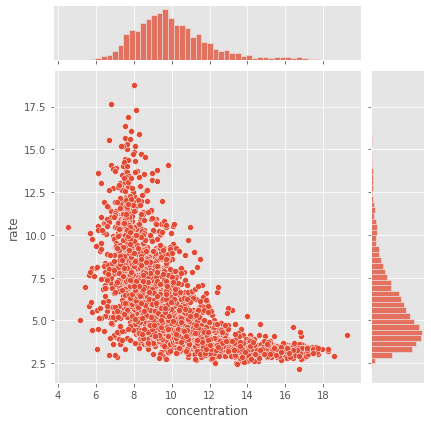

In [102]:
sns.jointplot(data=pred_params, x="concentration", y="rate")

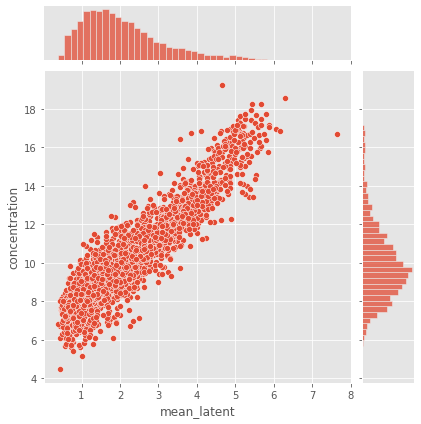

In [103]:
sns.jointplot(data=pred_params, x="mean_latent", y="concentration")

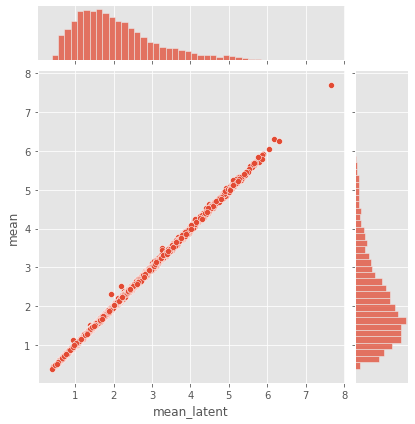

In [104]:
sns.jointplot(data=pred_params, x="mean_latent", y="mean")

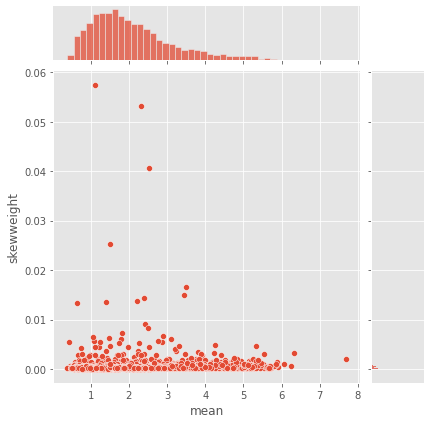

In [105]:
sns.jointplot(data=pred_params, x="mean", y="skewweight")

<Axes: xlabel='mean'>

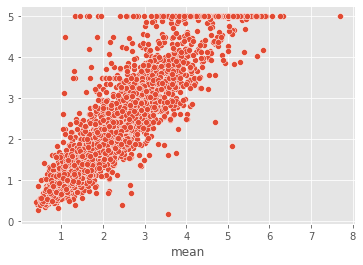

In [106]:
sns.scatterplot(x=pred_params["mean"], y=y_test)

# SHAP Interpretability

[18:36:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


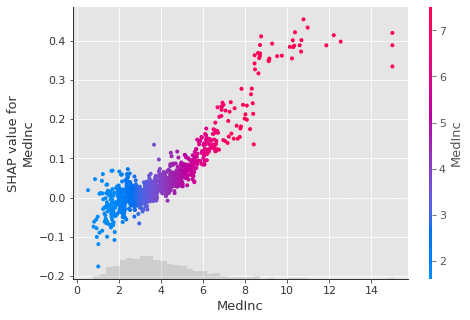

In [107]:
# Partial Dependence Plot
pdp_df = pd.DataFrame(X_train, columns=feature_names)
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="concentration",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

[18:37:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


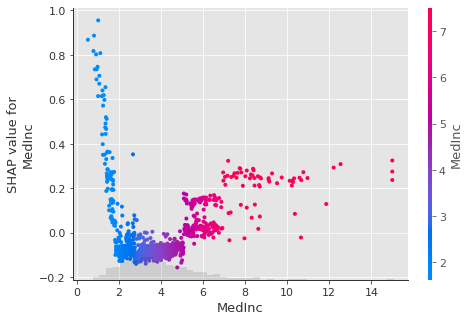

In [108]:
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="skewweight",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

[18:37:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


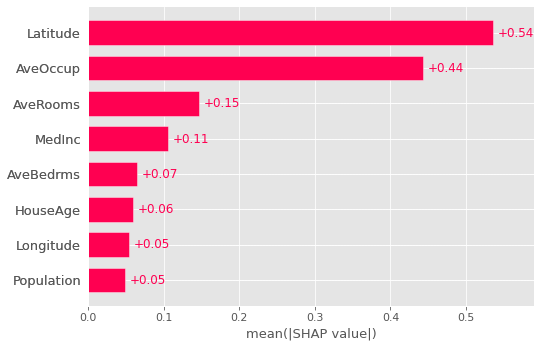

In [109]:
# Feature Importance
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="skewweight",
            plot_type="Feature_Importance")

[18:37:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


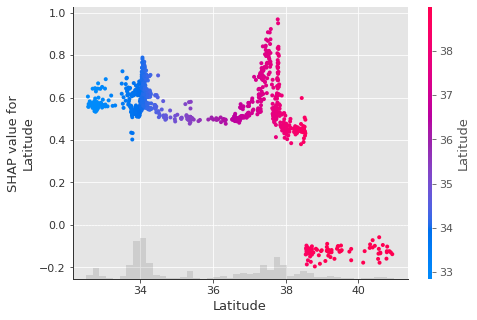

In [111]:
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="skewweight",
            feature="Latitude",
            plot_type="Partial_Dependence")